In [599]:
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from scipy.signal import fftconvolve
from scipy.fftpack import fft
from scipy.linalg import dft
from scipy.io import wavfile

import pandas as pd
import numpy as np
import IPython
import time
import math
import os

import warnings

In [602]:
warnings.filterwarnings('ignore')

In [265]:
class SoundWave(object):
    """A class for working with digital audio signals."""

    # Problem 1.1
    def __init__(self, rate, samples):
        """Set the SoundWave class attributes.

        Parameters:
            rate (int): The sample rate of the sound.
            samples ((n,) ndarray): NumPy array of samples.
        """
        self.rate = rate
        self.samples = samples

    # Problems 1.1 and 1.7
    def plot(self, plot_transform = False):
        """Plot the graph of the sound wave (time versus amplitude)."""
        
        if plot_transform == False:
            time = np.linspace(0, len(self.samples) / self.rate, len(self.samples))
        
            plt.plot(time, self.samples)
            plt.ylim((-32768,32767))
            plt.title("Waveform")
        
            plt.show()
        
        if plot_transform == True:
            transform = np.abs(fft(self.samples))
            
            time = np.linspace(0, len(self.samples) / self.rate, len(self.samples))
            freq = np.arange(0, len(self.samples)) * self.rate / len(self.samples)
            
            ax2 = plt.subplot(121)
            ax2.plot(time, self.samples)
            ax2.set_ylim((-32768, 32767))
            ax2.set_title("Waveform")
            
            ax1 = plt.subplot(122)
            ax1.plot(freq, transform)
            ax1.set_xlim((0,self.rate / 2))
            ax1.set_title("Frequencies")
                         
            plt.show()

    # Problem 1.2
    def export(self, filename, force=False):
        """Generate a wav file from the sample rate and samples. 
        If the array of samples is not of type np.int16, scale it before exporting.

        Parameters:
            filename (str): The name of the wav file to export the sound to.
        """
        if force==True or self.samples.dtype!='int16':
            scaled_samples = np.int16((self.samples * 32767.0)/max(self.samples))
            wavfile.write(filename, self.rate, scaled_samples)
            
        else:
            wavfile.write(filename, self.rate, self.samples)
    
    # Problem 1.4
    def __add__(self, other):
        """Combine the samples from two SoundWave objects.

        Parameters:
            other (SoundWave): An object containing the samples to add
                to the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the combined samples.

        Raises:
            ValueError: if the two sample arrays are not the same length.
        """
        if len(self.samples)!=len(other.samples):
            raise ValueError("Samples not the same length!")
            
        new_sample = self.samples + other.samples
        return SoundWave(self.rate, new_sample)
        

    # Problem 1.4
    def __rshift__(self, other):
        """Concatentate the samples from two SoundWave objects.

        Parameters:
            other (SoundWave): An object containing the samples to concatenate
                to the samples contained in this object.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        if self.rate != other.rate:
            raise ValueError("Samples not the same length!")
            
        new_sample = np.concatenate((self.samples, other.samples))
        
        return SoundWave(self.rate, new_sample)
    
    # Problem 2.1
    def __mul__(self, other):
        """Convolve the samples from two SoundWave objects using circular convolution.
        
        Parameters:
            other (SoundWave): An object containing the samples to convolve
                with the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the convolved samples.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        #Ensure rates are the same
        if self.rate!=other.rate:
            raise ValueError("Sample rates are different!")
        
        #Pad smaller array with zeros
        if len(self.samples)< len(other.samples):
            padded_f = np.concatenate((self.samples,np.zeros(len(other.samples) - len(self.samples))))
            padded_g = other.samples
        elif len(self.samples)>len(other.samples):
            padded_g = np.concatenate((other.samples,np.zeros(len(self.samples) - len(other.samples))))
            padded_f = self.samples
            
        #Get transformed sample sets to multipy component wise
        f_trans = fft(padded_f).real
        g_trans = fft(padded_g).real
        
        hadamard = np.multiply(f_trans,g_trans)
        
        convolution = ifft(hadamard).real
        
        #Return new SoundWave with rate = self.rate and samples = our convoluted SoundWaves
        return SoundWave(self.rate, convolution)


    # Problem 2.2
    def __pow__(self, other):
        """Convolve the samples from two SoundWave objects using linear convolution.
        
        Parameters:
            other (SoundWave): An object containing the samples to convolve
                with the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the convolved samples.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        #Get lengths to use
        n = len(self.samples)
        m = len(other.samples)
        sample_length = n + m - 1
  
        #Find smallest power of 2 >= n + m - 1
        while math.log(sample_length, 2) != int(math.log(sample_length, 2)):
            sample_length += 1
            
        #Pad samples with zeros
        padded_f = np.concatenate((self.samples,np.zeros(sample_length - n)))
        padded_g = np.concatenate((other.samples,np.zeros(sample_length - m)))
           
        #Transform and get hadamard
        hadamard = np.multiply(fft(padded_f).real, fft(padded_g).real)
        
        #Inverse fourier transform on the hadamard product
        convolution = ifft(hadamard).real
     
        #Return new SoundWave with rate = self.rate and samples = our convoluted SoundWaves
        return SoundWave(self.rate, convolution[:n+m-1])
    
    # Problem 2.4
    def clean(self, low_freq, high_freq):
        """Remove a range of frequencies from the samples using the DFT. 

        Parameters:
            low_freq (float): Lower bound of the frequency range to zero out.
            high_freq (float): Higher boound of the frequency range to zero out.
        """
        #Get frequency by  set and length of sample size
        f = fft(self.samples)
        n = len(self.samples)
        
        #Find k_low and k_high using k = nv/r
        k_low = int(n*low_freq/self.rate)
        k_high = int(n*high_freq/self.rate)
        
        #Replace both intervals of high frequency with zero
        zeros = [0]*len(f)
        f[k_low:k_high] = zeros[k_low:k_high]
        f[n-k_high:n-k_low] = zeros[n-k_high:n-k_low]

        return SoundWave(self.rate, ifft(f).real)

In [399]:
def load_data(directory='raw_data'):
    """
    Function to load sound data from the donateacry dataset.
    Also normalizes each to have the same length.
    
    Parameters
    ----------
    directory : str
                directory to search for data
    scale     : bool
                indicates whether to scale data or not
    
    Returns
    -------
    wavforms : ndarray
               array of data points (each waveform)
    labels : ndarray
             array of labels corresponding to each waveform
    """
    subdirs = os.listdir(directory)
    wavforms = []
    labels = []
    for dirc in subdirs:
        filenames = os.listdir(directory+'/'+dirc)
        for filename in filenames:
            # Get wavform from each file 
            wav = wavfile.read(directory+'/'+dirc+'/'+filename)[1]
                
            # Store wavform and appropriate label
            wavforms.append(wav)
            labels.append(dirc)
    
    # Find the minimum wavform length.
    lens = set()
    for d in wavforms:
        lens.add(len(d))
    min_len = min(lens)
    
    # Cut the end off each wavform so they're the same lengths.
    for i,wav in enumerate(wavforms):
        wavforms[i] = wav[:min_len]
        
    return np.array(wavforms), np.array(labels)

def cut_data(data, labels, n):
    """
    Takes data and cuts each sample into parts of specified length
    
    Parameters
    ----------
    data   : ndarray
             array of waveform values of constant length
    labels : ndarray
             array of labels for each row of data
    n.     : int
             desired length of new samples
             
    Returns
    -------
    new_data   : ndarray
                 array of new cut samples
    new_labels : ndarray
                 array of corresponding labels
    """
    new_data = []
    new_labels = []
    # Get number of possible subsamples from current samples
    subs = data.shape[1]//n

    # Cut each sample
    for i, wav in enumerate(data):
        # Get as many new samples from old sample as possible
        for x in range(subs):
            # Extract subsamples of length n
            new_data.append(wav[x*n:(x+1)*n])
            # Store corresponding label
            new_labels.append(labels[i])
            
    return np.array(new_data), np.array(new_labels)

def duplicate_data(data, labels, alpha=0.3333):
    """
    Duplicates data and adds random noise to the duplicates.
    
    Parameters
    ----------
    data (ndarray): array of waveform values.
    labels (ndarray): array of labels for each row of data.
    alpha (float): a parameter that changes how large the noise may be for 
            all waveforms relative to each of their sample values.
        
    Returns
    -------
    new_data (ndarray): all the same rows as data with noisy rows as well
    new_labels (ndarray): the labels corresponding to the rows of new_data
    """
    new_data = []
    new_labels = []
    for wav, label in zip(data, labels):
        # Sample noise from the normal distribution.
        noise = np.array([np.random.normal(scale=max(abs(x)*alpha, 0)) for x in wav])
        
        new_wav = wav.astype(np.int64) + noise.astype(np.int64)
        
        # Rescale the new_wav to make sure no parts go above 32767.
        new_wav = np.array(32767*new_wav/np.max(np.abs(new_wav))).astype(np.int16)
        
        new_data.append(new_wav)
        new_labels.append(label)
    
    # Concatenate the old and new data/labels.
    new_data = np.vstack([data, np.array(new_data)])
    new_labels = np.hstack([labels, np.array(new_labels)])
    
    return new_data, new_labels

def get_fft(data, rate=8000, sample_rate=100):
    """
    Function to transform wavelength data into frequency data using the FFT
    
    Parameters
    ----------
    data        : ndarray
                  Array where each row is the wavelength samples of a single cry instance
    sample_rate : int
                  rate to subsample the frequencies at
           
    Returns
    -------
    freqs       : ndarray
                  Array whose rows are the sampled frequencies
    freq_domain : domain of frequency values
    """
    freqs = []
    freq_domain = np.arange(0, len(data[0])) * rate / len(data[0])
    freq_domain = freq_domain[:len(freq_domain)//2]
    
    for i, wav in enumerate(data):
        # Get frequencies using Fourier Transform
        f = np.abs(fft(wav))[:len(freq_domain)]
        # Get real part of frequencies, normalize, and sample at the sample rate
        tmp = (np.real(f) / max(np.real(f)))[::sample_rate]
        freqs.append(list(tmp))
    
    return np.array(freqs), freq_domain[::sample_rate]

def data_to_df(data, labels, freqs):
    """
    Function to convert numpy array of data to a pandas DataFrame
    
    Parameters
    ----------
    data  : ndarray
            Array whose rows are of the form [[frequencies], 'label']
    label : list or ndarray of shape (n,)
            list of labels corresponding to each row of data
    freqs : list or ndarray of shape (n,)
            Frequency domain of the passed data (used to make column names)
    
    Returns
    -------
    df : pd.DataFrame
         DataFrame where each row is a cry instance and each column is a frequency
         with a final 'label' column
    """
    # Data to df
    df = pd.DataFrame(data,columns=freqs)
    # Labels column
    df['labels'] = labels
    return df

def labels_to_integers(labels):
    """
    Convert the array of all labels (strings) to integer values.
    
    Parameters
    ----------
    labels (ndarray): array of strings containing the label name for
        each data point
    
    Returns
    -------
    new_labels (ndarray): array where labels are replaced with ints
    mapping (dict): a mapping from int -> string showing which integer
        corresponds to which label
    """
    new_labels = np.zeros(labels.shape)
    mapping = {}
    
    for idx, lab in enumerate(np.unique(labels)):
        new_labels[labels==lab] = idx
        mapping[idx] = lab
    
    return new_labels, mapping

## Data Preparation

In [295]:
data, labels = load_data('raw_data')

In [604]:
set(labels)

{'belly_pain', 'burping', 'discomfort', 'hungry', 'tired'}

In [303]:
print('|{0}\t|{1}\t|{2}\t|{3}\t|{4}\t|{5}\t|{6}'.format('# samples', 'avg len', 
                                                       'avg min wvl', 'avg max wvl', 
                                                       'abs min wvl', 'abs max wvl', 'label'))
print('------------------------------------------------------------------------------------------------------')
for label in set(labels):
    tmp = data[labels==label]
    num_samples = len(tmp)
    avg_len = sum(len(row) for row in tmp)/num_samples
    avg_max_wvl = sum([max(row) for row in tmp])/num_samples
    avg_min_wvl = sum([min(row) for row in tmp])/num_samples
    abs_min_wvl = min([min(row) for row in tmp])
    abs_max_wvl = max([max(row) for row in tmp])
    print(u"|{0}\t\t|{1:0.2f}\t|{2:0.2f}\t|{3:0.2f}\t|{4:0.2f}\t|{5:0.2f}\t|{6}".format(num_samples, avg_len, 
                                                                                  avg_min_wvl, avg_max_wvl, 
                                                                                  abs_min_wvl, abs_max_wvl,
                                                                                  label))

|# samples	|avg len	|avg min wvl	|avg max wvl	|abs min wvl	|abs max wvl	|label
------------------------------------------------------------------------------------------------------
|24		|52160.00	|-15448.79	|15984.58	|-32768.00	|32767.00	|tired
|8		|52160.00	|-25814.88	|26556.88	|-32768.00	|32767.00	|burping
|27		|52160.00	|-17641.41	|18598.74	|-32768.00	|32767.00	|discomfort
|382		|52160.00	|-19543.69	|20013.27	|-32768.00	|32767.00	|hungry
|16		|52160.00	|-15364.62	|13974.56	|-32768.00	|32767.00	|belly_pain


In [361]:
non_hungry_data = data[labels!='hungry']
non_hungry_labels = labels[labels!='hungry']
cut_data, cut_labels = cut_data(non_hungry_data,non_hungry_labels, 25000)
dup_data, dup_labels = duplicate_data(cut_data,cut_labels)

In [370]:
hungry_data = data[labels=='hungry'][:100]
hungry_labels = ['hungry']*100
hungry_data = hungry_data[:,:25000]

In [377]:
final_data = np.vstack((hungry_data,dup_data))
final_labels = np.hstack((hungry_labels, dup_labels))

In [400]:
X, f_domain = get_fft(final_data)

In [401]:
print('|{0}\t|{1}\t|{2}\t|{3}\t|{4}\t|{5}\t|{6}'.format('# samples', 'avg len', 
                                                       'avg min freq', 'avg max freq', 
                                                       'abs min freq', 'abs max freq', 'label'))
print('------------------------------------------------------------------------------------------------------')
for label in set(final_labels):
    tmp = X[final_labels==label]
    num_samples = len(tmp)
    avg_len = sum(len(row) for row in tmp)/num_samples
    avg_max_wvl = sum([max(row) for row in tmp])/num_samples
    avg_min_wvl = sum([min(row) for row in tmp])/num_samples
    abs_min_wvl = min([min(row) for row in tmp])
    abs_max_wvl = max([max(row) for row in tmp])
    print(u"|{0}\t\t|{1:0.2f}\t\t|{2:0.2f}\t\t|{3:0.2f}\t\t|{4:0.2f}\t\t|{5:0.2f}\t\t|{6}".format(num_samples, avg_len, 
                                                                                  avg_min_wvl, avg_max_wvl, 
                                                                                  abs_min_wvl, abs_max_wvl,
                                                                                  label))

|# samples	|avg len	|avg min freq	|avg max freq	|abs min freq	|abs max freq	|label
------------------------------------------------------------------------------------------------------
|96		|125.00		|0.00		|0.52		|0.00		|0.98		|tired
|32		|125.00		|0.00		|0.60		|0.00		|0.84		|burping
|108		|125.00		|0.00		|0.59		|0.00		|1.00		|discomfort
|64		|125.00		|0.00		|0.55		|0.00		|0.98		|belly_pain
|100		|125.00		|0.00		|0.58		|0.00		|1.00		|hungry


## PCA

% of Explained Variance:
[2.07690666e-01 7.85561519e-02 5.27135852e-02 4.16323975e-02
 3.94818525e-02 3.40229837e-02 3.13981105e-02 2.40160054e-02
 2.31066469e-02 2.19516898e-02 2.07168951e-02 1.95001679e-02
 1.74812058e-02 1.67863841e-02 1.63708305e-02 1.47860324e-02
 1.38198501e-02 1.35588569e-02 1.23111510e-02 1.19931357e-02
 1.13249057e-02 1.11035723e-02 9.97844586e-03 9.75250137e-03
 9.34145057e-03 8.92824700e-03 8.62666286e-03 8.29423764e-03
 7.93403376e-03 7.75542643e-03 7.36134025e-03 7.23794722e-03
 6.96242491e-03 6.37044938e-03 6.30713650e-03 6.12254437e-03
 5.92935022e-03 5.68017111e-03 5.46616242e-03 5.20856705e-03
 5.02847836e-03 4.88347963e-03 4.62576925e-03 4.52926030e-03
 4.45461238e-03 4.37706799e-03 4.20145252e-03 4.03884081e-03
 3.90467341e-03 3.75600447e-03 3.72179310e-03 3.45160778e-03
 3.43338274e-03 3.33364652e-03 3.14149285e-03 3.04402235e-03
 3.01737911e-03 2.83582853e-03 2.78286534e-03 2.72173426e-03
 2.64997404e-03 2.57417351e-03 2.45082559e-03 2.34174739e-03

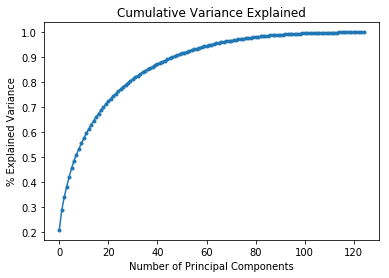

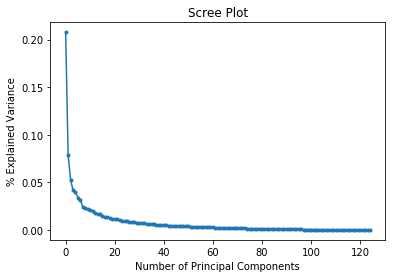

In [403]:
p = PCA()
p.fit_transform(X)
var = p.explained_variance_ratio_
print('% of Explained Variance:')
print(var)
plt.plot(np.cumsum(var), '.-')
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Principal Components')
plt.ylabel('% Explained Variance')
plt.show()

plt.plot(var, '.-')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('% Explained Variance')
plt.show()

% of Explained Variance:
[5.39766628e-02 3.27607647e-02 3.05775060e-02 2.78276877e-02
 2.23040192e-02 1.90267752e-02 1.75525026e-02 1.72688143e-02
 1.70184779e-02 1.66914689e-02 1.63763946e-02 1.61620104e-02
 1.52923127e-02 1.47933539e-02 1.45867743e-02 1.41849694e-02
 1.41054158e-02 1.40697209e-02 1.34612174e-02 1.28449798e-02
 1.23521988e-02 1.21405682e-02 1.21025250e-02 1.17030626e-02
 1.08351086e-02 1.05419507e-02 1.01874740e-02 9.19711867e-03
 8.82527951e-03 8.58273766e-03 8.41707422e-03 8.31355472e-03
 7.55382733e-03 7.35052364e-03 7.20211024e-03 7.00750601e-03
 6.86447386e-03 6.57659105e-03 6.49211131e-03 6.30682762e-03
 6.14781532e-03 6.07855342e-03 6.02118403e-03 5.97912061e-03
 5.91954941e-03 5.65195995e-03 5.61933107e-03 5.56460602e-03
 5.46536975e-03 5.25393523e-03 5.11031596e-03 4.95582182e-03
 4.91539570e-03 4.88908901e-03 4.88199191e-03 4.83525778e-03
 4.70997061e-03 4.68516427e-03 4.66174156e-03 4.56494963e-03
 4.53577771e-03 4.44286193e-03 4.35029806e-03 4.32879767e-03

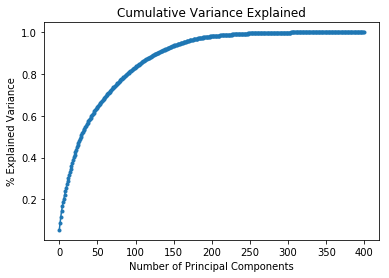

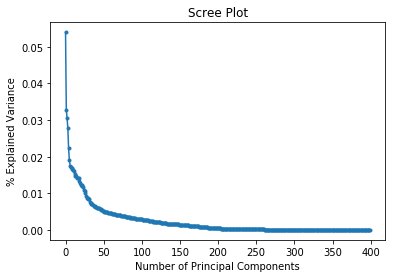

In [475]:
p = PCA()
p.fit_transform(final_data)
var = p.explained_variance_ratio_
print('% of Explained Variance:')
print(var)
plt.plot(np.cumsum(var), '.-')
plt.title('Cumulative Variance Explained')
plt.xlabel('Number of Principal Components')
plt.ylabel('% Explained Variance')
plt.show()

plt.plot(var, '.-')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('% Explained Variance')
plt.show()

In [432]:
# Find how many principal components explain 90% of variance
s = 0
count = 0
for item in var:
    s += item
    count+=1
    if s >= .9:
        break
print('Fourier data')
print('# of components that explain 90% of the variance:',count)

# of components that explain 90% of the variance: 48


In [477]:
# Find how many principal components explain 90% of variance
s = 0
count = 0
for item in var:
    s += item
    count+=1
    if s >= .9:
        break
print('Raw data')
print('# of components that explain 90% of the variance:',count)

Raw data
# of components that explain 90% of the variance: 130


In [478]:
# Get first 48 principal components
fp = PCA(48)
fcomps = fp.fit_transform(X)

In [479]:
p = PCA(130)
comps = p.fit_transform(final_data)

## Train-Test-Split

### Fourier

In [575]:
int_labels = labels_to_integers(final_labels)[0]
fcX_train, fcX_test, fcy_train, fcy_test = tts(fcomps, int_labels)
fX_train, fX_test, fy_train, fy_test = tts(X, int_labels)

### Raw data

In [574]:
int_labels = labels_to_integers(final_labels)[0]
cX_train, cX_test, cy_train, cy_test = tts(comps, int_labels)
X_train, X_test, y_train, y_test = tts(final_data, int_labels)

## Support Vector Machine

In [498]:
clf = SVC()
clf.fit(fcX_train, fcy_train)
preds = clf.predict(fcX_test)
preds

/Users/jakecallahan/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [499]:
clf = SVC()
clf.fit(cX_train, cy_train)
preds = clf.predict(cX_test)
preds

/Users/jakecallahan/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [500]:
clf = SVC()
clf.fit(fX_train, fy_train)
preds = clf.predict(fX_test)
preds

/Users/jakecallahan/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [465]:
len(y_train[y_train=='p'])

/Users/jakecallahan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


0

## Random Forest

In [598]:
clf = RFC()
clf.fit(cX_train,cy_train)
preds = clf.predict(cX_test)
print(classification_report(preds,cy_test))

              precision    recall  f1-score   support

         0.0       0.71      0.52      0.60        23
         1.0       0.20      0.50      0.29         4
         2.0       0.55      0.34      0.42        35
         3.0       0.24      0.58      0.34        12
         4.0       0.55      0.46      0.50        26

   micro avg       0.45      0.45      0.45       100
   macro avg       0.45      0.48      0.43       100
weighted avg       0.53      0.45      0.47       100



/Users/jakecallahan/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [605]:
final_data.shape

(400, 25000)